In [1]:
!kaggle datasets download -d hamdallak/the-iqothnccd-lung-cancer-dataset

Dataset URL: https://www.kaggle.com/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset
License(s): CC0-1.0
 93% 139M/149M [00:01<00:00, 114MB/s]
100% 149M/149M [00:01<00:00, 81.9MB/s]


In [2]:
!unzip -q /content/the-iqothnccd-lung-cancer-dataset.zip

In [5]:
# !pip install ultralytics

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 874.0/874.0 kB 23.1 MB/s eta 0:00:00


In [6]:
import os
import random
import shutil
import cv2
import glob
import yaml
import matplotlib.pyplot as plt
import ultralytics
import numpy as np
import torch
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ‚úÖ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [7]:
random.seed(2024)

In [8]:
data_root = '/content/The IQ-OTHNCCD lung cancer dataset'
file_root = f'{data_root}/data'
project_name = 'lung_cancer'

In [9]:
# Ï†ïÎ¶¨Ìï† ÎîîÎ†âÌÜ†Î¶¨ Ï†ïÏùò

train_file_root = f'{data_root}/{project_name}'
train_root = f'{data_root}/{project_name}/train'
val_root = f'{data_root}/{project_name}/val'
test_root = f'{data_root}/{project_name}/test'

In [11]:
# Bengin cases, Maligant cases, Normal cases ÎîîÎ†âÌÜ†Î¶¨Î•º data ÎîîÎ†âÌÜ†Î¶¨ ÏïàÏúºÎ°ú ÎÑ£Ïñ¥Ï§å

cls_list = os.listdir(file_root)
cls_list

['Malignant cases', 'Normal cases', 'Bengin cases']

In [12]:
for folder in [train_root, val_root, test_root] :

    if not os.path.exists(folder) :
        os.makedirs(folder)

    for cls in cls_list :
        cls_folder = f'{folder}/{cls}'

        if not os.path.exists(cls_folder) :
            os.makedirs(cls_folder)

In [13]:
for cls in cls_list :
    file_list = os.listdir(f'{file_root}/{cls}')
    random.shuffle(file_list)
    test_ratio = 0.1
    num_file = len(file_list)
    # print(num_file)

    test_list= file_list[: int(num_file * test_ratio)]
    val_list = file_list[int(num_file * test_ratio) : int(num_file * test_ratio) * 2]
    train_list = file_list[int(num_file * test_ratio) * 2 : ]

    for i in test_list :
        shutil.copyfile(f'{file_root}/{cls}/{i}', f'{test_root}/{cls}/{i}')

    for i in val_list :
        shutil.copyfile(f'{file_root}/{cls}/{i}', f'{val_root}/{cls}/{i}')

    for i in train_list :
        shutil.copyfile(f'{file_root}/{cls}/{i}', f'{train_root}/{cls}/{i}')

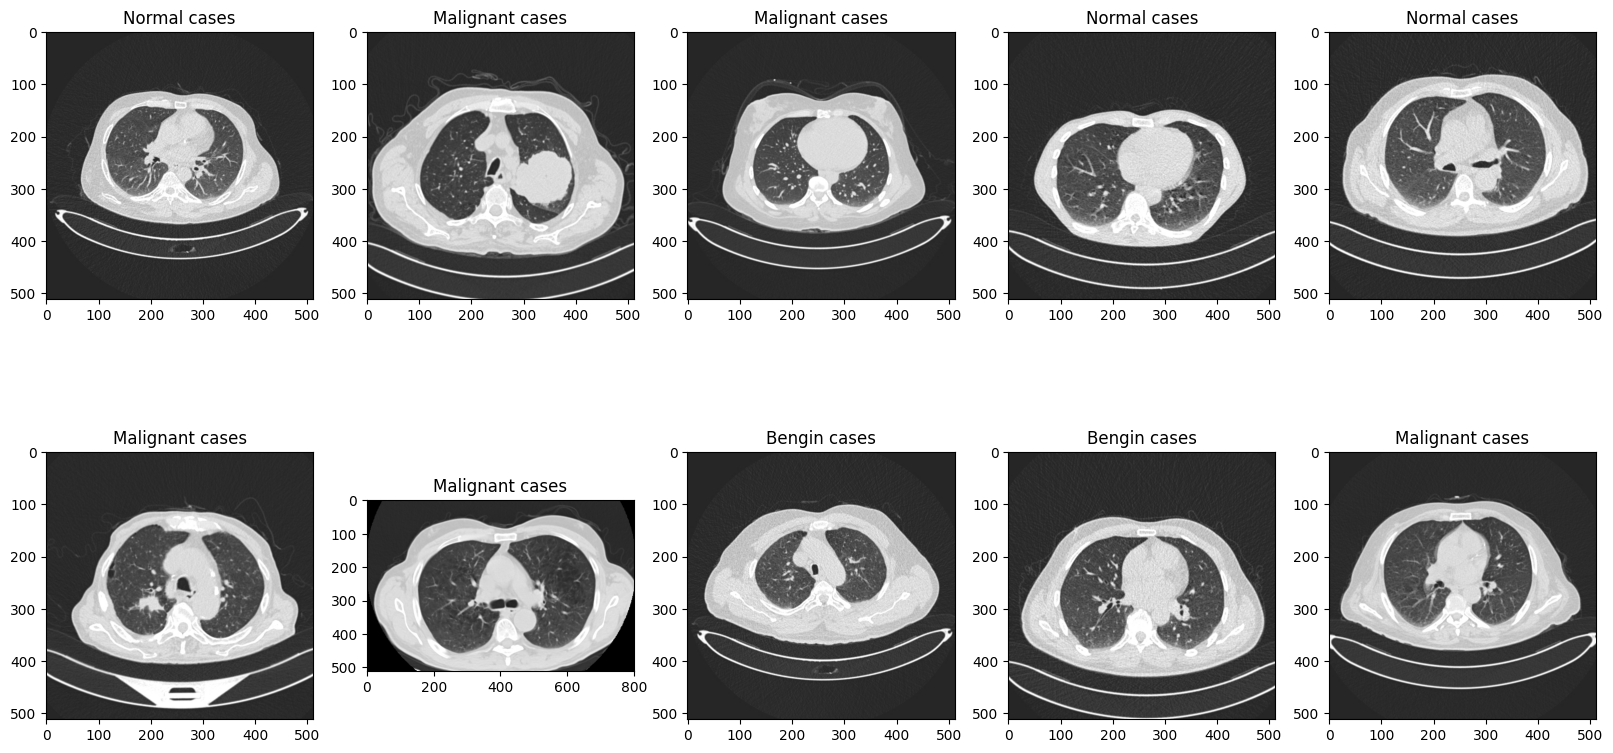

In [14]:
test_file_list= glob.glob(f'{test_root}/*/*')
# print(test_file_list)
random.shuffle(test_file_list)

plt.figure(figsize = (20, 10))

for i in range(10) :
    test_img_path = os.path.join(test_root, test_file_list[i])
    ori_img = Image.open(test_img_path).convert('RGB')

    plt.subplot(2, 5, i + 1)
    plt.title(test_file_list[i].split('/')[-2])
    plt.imshow(ori_img)

plt.show()

In [15]:
project_root = '/content/The IQ-OTHNCCD lung cancer dataset/lung_cancer'

In [16]:
data = dict()
data['train'] = train_root
data['val'] = val_root
data['test'] = test_root
data['nc'] = len(cls_list)
data['names'] = cls_list

with open(f'{project_root}/lung_cancer.yaml', 'w') as f :
    yaml.dump(data, f)

In [17]:
ultralytics.checks()

Ultralytics YOLOv8.2.99 üöÄ Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ‚úÖ (2 CPUs, 12.7 GB RAM, 33.0/112.6 GB disk)


In [18]:
%cd /content/The IQ-OTHNCCD lung cancer dataset/lung_cancer

/content/The IQ-OTHNCCD lung cancer dataset/lung_cancer


In [19]:
model = YOLO('yolov8s-cls.pt')

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12.3M/12.3M [00:00<00:00, 111MB/s] 


In [20]:
# patience : Ï°∞Í∏∞ Ï¢ÖÎ£å(Early Stompping), Î™®Îç∏Ïùò ÏÑ±Îä•Ïù¥ Îçî Ïù¥ÏÉÅ Í∞úÏÑ† ÎêòÏßÄ ÏïäÏùÑ Îïå Ï°∞Í∏∞ Ï¢ÖÎ£åÎ•º ÏúÑÌïú Í∞í
# Ïòà) patience = 30 : ÏÑ±Îä•Ïù¥ Í∞úÏÑ†ÎêòÏßÄ ÏïäÎäî epoch Í∞Ä 30Î≤à Ïù¥ÏÉÅ ÏßÄÏÜçÎêòÎ©¥ ÌïôÏäµÏùÑ Ï°∞Í∏∞ Ï¢ÖÎ£å

results = model.train(data = f'{data_root}/{project_name}', epochs = 50, batch = 8, device = 0, name = 'lung_cancer_s', patience = 30)

Ultralytics YOLOv8.2.99 üöÄ Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8s-cls.pt, data=/content/The IQ-OTHNCCD lung cancer dataset/lung_cancer, epochs=50, time=None, patience=30, batch=8, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=lung_cancer_s, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6.25M/6.25M [00:00<00:00, 107MB/s]


AMP: checks passed ‚úÖ


train: Scanning /content/The IQ-OTHNCCD lung cancer dataset/lung_cancer/train... 879 images, 0 corrupt: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 879/879 [00:00<00:00, 3713.88it/s]

train: New cache created: /content/The IQ-OTHNCCD lung cancer dataset/lung_cancer/train.cache



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/The IQ-OTHNCCD lung cancer dataset/lung_cancer/val... 109 images, 0 corrupt: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 109/109 [00:00<00:00, 2540.70it/s]

val: New cache created: /content/The IQ-OTHNCCD lung cancer dataset/lung_cancer/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ‚úÖ
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/lung_cancer_s
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/50     0.348G      1.128          8        224:   8%|‚ñä         | 9/110 [00:01<00:10,  9.81it/s]

       1/50     0.348G      1.119          8        224:  16%|‚ñà‚ñã        | 18/110 [00:02<00:07, 12.50it/s]
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 755k/755k [00:00<00:00, 19.0MB/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 11.67it/s]

                   all      0.862          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 15.59it/s]

                   all      0.881          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 16.47it/s]

                   all      0.881          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00,  8.46it/s]

                   all       0.89          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 18.11it/s]

                   all      0.927          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 13.67it/s]

                   all      0.927          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00,  8.44it/s]

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 14.55it/s]

                   all      0.927          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 16.58it/s]

                   all      0.945          1



      Epoch    GPU_mem       loss  Instances       Size


      10/50     0.321G     0.1788          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:09<00:00, 11.47it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00,  7.75it/s]

                   all      0.945          1



      Epoch    GPU_mem       loss  Instances       Size


      11/50     0.321G     0.1896          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:08<00:00, 12.98it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 14.45it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


      12/50     0.321G      0.173          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:10<00:00, 10.36it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 16.61it/s]

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


      13/50     0.321G     0.1619          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:09<00:00, 11.14it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00,  7.48it/s]

                   all      0.972          1



      Epoch    GPU_mem       loss  Instances       Size


      14/50     0.321G     0.1476          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:08<00:00, 12.77it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 15.56it/s]

                   all      0.972          1



      Epoch    GPU_mem       loss  Instances       Size


      15/50     0.321G     0.1278          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:11<00:00,  9.91it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 14.26it/s]

                   all      0.945          1



      Epoch    GPU_mem       loss  Instances       Size


      16/50     0.321G     0.1331          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:09<00:00, 11.37it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:01<00:00,  6.79it/s]

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


      17/50     0.321G      0.131          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:09<00:00, 12.08it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 14.12it/s]

                   all      0.963          1



      Epoch    GPU_mem       loss  Instances       Size


      18/50     0.321G     0.1239          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:11<00:00,  9.94it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 14.49it/s]

                   all      0.963          1



      Epoch    GPU_mem       loss  Instances       Size


      19/50     0.321G    0.09682          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:09<00:00, 12.15it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00,  8.01it/s]

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


      20/50     0.321G     0.1063          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:09<00:00, 11.49it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 14.18it/s]

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


      21/50     0.321G    0.07802          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:11<00:00,  9.79it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 14.07it/s]

                   all      0.972          1



      Epoch    GPU_mem       loss  Instances       Size


      22/50     0.323G     0.1102          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:09<00:00, 11.28it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00,  7.45it/s]

                   all      0.945          1



      Epoch    GPU_mem       loss  Instances       Size


      23/50     0.323G    0.09548          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:09<00:00, 11.49it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 14.72it/s]

                   all      0.972          1



      Epoch    GPU_mem       loss  Instances       Size


      24/50     0.321G    0.08137          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:12<00:00,  9.07it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 12.79it/s]

                   all      0.963          1



      Epoch    GPU_mem       loss  Instances       Size


      25/50     0.321G    0.05857          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:10<00:00, 10.60it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00,  7.92it/s]

                   all      0.972          1



      Epoch    GPU_mem       loss  Instances       Size


      26/50     0.321G     0.0698          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:09<00:00, 12.14it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 14.47it/s]

                   all      0.982          1



      Epoch    GPU_mem       loss  Instances       Size


      27/50     0.321G    0.07668          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:11<00:00,  9.35it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 13.34it/s]

                   all      0.972          1



      Epoch    GPU_mem       loss  Instances       Size


      28/50     0.321G    0.05707          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:11<00:00,  9.94it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00,  7.83it/s]

                   all      0.982          1



      Epoch    GPU_mem       loss  Instances       Size


      29/50     0.321G    0.03975          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:14<00:00,  7.48it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:01<00:00,  4.78it/s]

                   all      0.982          1



      Epoch    GPU_mem       loss  Instances       Size


      30/50     0.323G    0.03181          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:09<00:00, 11.81it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 11.14it/s]

                   all      0.982          1



      Epoch    GPU_mem       loss  Instances       Size


      31/50     0.321G     0.0651          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:11<00:00,  9.71it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 13.74it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      32/50     0.321G    0.04769          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:11<00:00,  9.51it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 12.55it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


      33/50     0.321G    0.04899          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:08<00:00, 12.46it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00,  9.12it/s]

                   all      0.982          1



      Epoch    GPU_mem       loss  Instances       Size


      34/50     0.321G     0.0598          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:10<00:00, 10.12it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 13.18it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


      35/50     0.321G    0.04609          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:14<00:00,  7.78it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 13.24it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


      36/50     0.321G    0.05145          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:12<00:00,  8.90it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00,  9.85it/s]

                   all      0.982          1



      Epoch    GPU_mem       loss  Instances       Size


      37/50     0.321G    0.04027          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:09<00:00, 11.25it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00,  8.92it/s]

                   all      0.972          1



      Epoch    GPU_mem       loss  Instances       Size


      38/50     0.321G    0.04636          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:09<00:00, 11.01it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 15.14it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


      39/50     0.321G     0.0394          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:11<00:00,  9.34it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 15.70it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      40/50     0.321G    0.03447          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:09<00:00, 11.51it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00,  8.36it/s]

                   all      0.972          1



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem       loss  Instances       Size


      41/50     0.321G    0.03922          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:09<00:00, 11.53it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 13.40it/s]

                   all      0.982          1



      Epoch    GPU_mem       loss  Instances       Size


      42/50     0.321G    0.04071          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:11<00:00,  9.68it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 13.48it/s]

                   all      0.972          1



      Epoch    GPU_mem       loss  Instances       Size


      43/50     0.321G    0.03332          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:10<00:00, 10.12it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00,  8.44it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


      44/50     0.321G    0.02063          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:08<00:00, 12.33it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 13.39it/s]

                   all      0.982          1



      Epoch    GPU_mem       loss  Instances       Size


      45/50     0.321G    0.03487          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:11<00:00,  9.34it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 14.97it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


      46/50     0.321G    0.03268          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:11<00:00,  9.49it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00,  7.54it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


      47/50     0.321G    0.03008          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:08<00:00, 12.76it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 13.58it/s]

                   all      0.982          1



      Epoch    GPU_mem       loss  Instances       Size


      48/50     0.321G    0.02671          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:11<00:00,  9.40it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 12.22it/s]

                   all      0.972          1



      Epoch    GPU_mem       loss  Instances       Size


      49/50     0.321G    0.02693          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:11<00:00,  9.83it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 14.78it/s]

                   all      0.972          1



      Epoch    GPU_mem       loss  Instances       Size


      50/50     0.321G     0.0317          7        224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 110/110 [00:08<00:00, 13.18it/s]
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 10.10it/s]

                   all      0.982          1



50 epochs completed in 0.165 hours.
Optimizer stripped from runs/classify/lung_cancer_s/weights/last.pt, 10.3MB
Optimizer stripped from runs/classify/lung_cancer_s/weights/best.pt, 10.3MB

Validating runs/classify/lung_cancer_s/weights/best.pt...
Ultralytics YOLOv8.2.99 üöÄ Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-cls summary (fused): 73 layers, 5,079,043 parameters, 0 gradients, 12.5 GFLOPs
train: /content/The IQ-OTHNCCD lung cancer dataset/lung_cancer/train... found 879 images in 3 classes ‚úÖ 
val: /content/The IQ-OTHNCCD lung cancer dataset/lung_cancer/val... found 109 images in 3 classes ‚úÖ 
test: /content/The IQ-OTHNCCD lung cancer dataset/lung_cancer/test... found 109 images in 3 classes ‚úÖ 


               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:01<00:00,  6.28it/s]


                   all          1          1
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/lung_cancer_s
Results saved to runs/classify/lung_cancer_s


In [21]:
result_folder = f'{project_root}/runs/classify/lung_cancer_s'

In [23]:
model = YOLO(f'{result_folder}/weights/best.pt')

In [24]:
# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Î°ú Í≤ÄÏ¶ù

metrics = model.val(split = 'test')

Ultralytics YOLOv8.2.99 üöÄ Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-cls summary (fused): 73 layers, 5,079,043 parameters, 0 gradients, 12.5 GFLOPs
train: /content/The IQ-OTHNCCD lung cancer dataset/lung_cancer/train... found 879 images in 3 classes ‚úÖ 
val: /content/The IQ-OTHNCCD lung cancer dataset/lung_cancer/val... found 109 images in 3 classes ‚úÖ 
test: /content/The IQ-OTHNCCD lung cancer dataset/lung_cancer/test... found 109 images in 3 classes ‚úÖ 


test: Scanning /content/The IQ-OTHNCCD lung cancer dataset/lung_cancer/test... 109 images, 0 corrupt: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 109/109 [00:00<00:00, 2133.87it/s]

test: New cache created: /content/The IQ-OTHNCCD lung cancer dataset/lung_cancer/test.cache



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
               classes   top1_acc   top5_acc: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:01<00:00,  4.28it/s]


                   all      0.991          1
Speed: 0.1ms preprocess, 2.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val


In [25]:
metrics

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79ff419b4610>
curves: []
curves_results: []
fitness: 0.9954128563404083
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9908257126808167, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9954128563404083}
save_dir: PosixPath('runs/classify/val')
speed: {'preprocess': 0.06253128751702264, 'inference': 2.79944314869172, 'loss': 0.0010302307408884032, 'postprocess': 0.0011045998389567805}
task: 'classify'
top1: 0.9908257126808167
top5: 1.0

In [27]:
# top1 : Î™®Îç∏Ïù¥ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏóêÏÑú Í∞ÄÏû• ÎÜíÏùÄ ÌôïÎ•†Î°ú ÏòàÏ∏°Ìïú Í∞íÏù¥ Ïã§Ï†ú Ï†ïÎãµÍ≥º ÏùºÏπòÌïòÎäî Í≤ΩÏö∞Ïùò ÎπÑÏú®
# top5 : Î™®Îç∏Ïù¥ ÏòàÏ∏°Ìïú ÏÉÅÏúÑ 5Í∞úÏùò Í≤∞Í≥º Ï§ë ÌïòÎÇòÎùºÎèÑ Ï†ïÎãµÏùÑ Ìè¨Ìï®Ìï† Í≤ΩÏö∞Ïùò ÎπÑÏú®ÏùÑ ÎÇòÌÉÄÎÇ∏Îã§

print('top1 accuracy : ', metrics.top1)
print('top5 accuracy : ', metrics.top5)

top1 accuracy :  0.9908257126808167
top5 accuracy :  1.0


In [34]:
IMG_SIZE = (512, 512)

test_data_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])

In [35]:
test_file_list[0]

'/content/The IQ-OTHNCCD lung cancer dataset/lung_cancer/test/Normal cases/Normal case (132).jpg'

In [36]:
img = Image.open(test_file_list[0]).convert('RGB')

In [37]:
img_src = test_data_transform(img)

print(img_src.shape)

torch.Size([3, 512, 512])


In [38]:
x_tensor = img_src.unsqueeze(0)

print(x_tensor.shape)

torch.Size([1, 3, 512, 512])


In [39]:
result = model(x_tensor)[0]


0: 512x512 Normal cases 0.71, Bengin cases 0.28, Malignant cases 0.00, 160.4ms
Speed: 1.2ms preprocess, 160.4ms inference, 33.7ms postprocess per image at shape (1, 3, 512, 512)


In [42]:
temp = model(x_tensor)

temp[0]


0: 512x512 Normal cases 0.71, Bengin cases 0.28, Malignant cases 0.00, 17.6ms
Speed: 1.0ms preprocess, 17.6ms inference, 20.8ms postprocess per image at shape (1, 3, 512, 512)


ultralytics.engine.results.Results object with attributes:

boxes: None
keypoints: None
masks: None
names: {0: 'Bengin cases', 1: 'Malignant cases', 2: 'Normal cases'}
obb: None
orig_img: array([[[38, 38, 38],
        [38, 38, 38],
        [38, 38, 38],
        ...,
        [38, 38, 38],
        [38, 38, 38],
        [38, 38, 38]],

       [[38, 38, 38],
        [38, 38, 38],
        [38, 38, 38],
        ...,
        [38, 38, 38],
        [38, 38, 38],
        [38, 38, 38]],

       [[38, 38, 38],
        [38, 38, 38],
        [38, 38, 38],
        ...,
        [38, 38, 38],
        [38, 38, 38],
        [38, 38, 38]],

       ...,

       [[38, 38, 38],
        [38, 38, 38],
        [38, 38, 38],
        ...,
        [38, 38, 38],
        [38, 38, 38],
        [38, 38, 38]],

       [[38, 38, 38],
        [38, 38, 38],
        [38, 38, 38],
        ...,
        [38, 38, 38],
        [38, 38, 38],
        [38, 38, 38]],

       [[38, 38, 38],
        [38, 38, 38],
        [38, 38, 38]

In [40]:
gt = test_file_list[0].split('/')[-2]

gt

'Normal cases'

In [45]:
print(torch.argmax(result.probs.data).item())
print(model.names)

pt = model.names[torch.argmax(result.probs.data).item()]

pt

2
{0: 'Bengin cases', 1: 'Malignant cases', 2: 'Normal cases'}


'Normal cases'

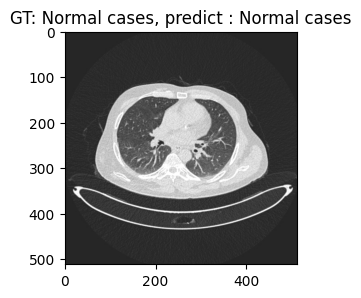

In [46]:
plt.figure(figsize = (3, 4))
plt.title(f'GT: {gt}, predict : {pt}')
plt.imshow(np.array(img))
plt.show()


0: 512x512 Normal cases 0.71, Bengin cases 0.28, Malignant cases 0.00, 11.4ms
Speed: 2.6ms preprocess, 11.4ms inference, 10.3ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 Malignant cases 0.49, Normal cases 0.38, Bengin cases 0.13, 6.4ms
Speed: 1.0ms preprocess, 6.4ms inference, 8.8ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 Normal cases 0.57, Bengin cases 0.24, Malignant cases 0.19, 6.6ms
Speed: 1.0ms preprocess, 6.6ms inference, 4.2ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 Normal cases 0.69, Bengin cases 0.31, Malignant cases 0.00, 7.8ms
Speed: 1.1ms preprocess, 7.8ms inference, 11.6ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 Normal cases 0.92, Bengin cases 0.08, Malignant cases 0.00, 5.7ms
Speed: 1.0ms preprocess, 5.7ms inference, 7.9ms postprocess per image at shape (1, 3, 512, 512)


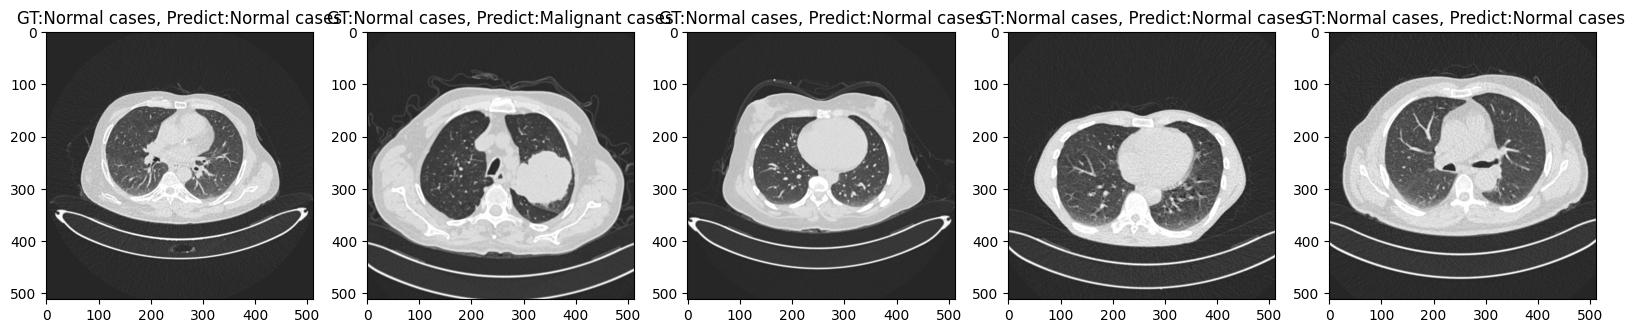

In [47]:
plt.figure(figsize=(20,5))

for idx in range(5):
    img = Image.open(test_file_list[idx]).convert('RGB')
    img_src = test_data_transform(img)
    x_tensor = img_src.unsqueeze(0)
    result = model.predict(x_tensor)[0]
    gt = test_file_list[0].split('/')[-2]
    pt = model.names[torch.argmax(result.probs.data).item()]
    plt.subplot(1, 5, (idx+1))
    plt.title(f'GT:{gt}, Predict:{pt}')
    plt.imshow(img)

plt.show()